In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from scipy.ndimage import gaussian_filter1d
from math import floor
import leidenalg as la
import igraph as ig
import csv
import networkx as nx

In [2]:
class temporal_network:#object for creating node-aligned(every node exists every layer)
                       #with diagonal coupling(inter-layer edges exist only between node to itself)
        
    ##################################
    # TODO: extend omega(scalar) for vector and matrix
    ##################################
        
    def __init__(self, size, length, data, **kwargs):
        
        if length < 1: raise ValueError('Object should be a multilayer network with at least 2 layers')
        if size < 3: raise ValueError('Layers must have at least 3 nodes')
        
        self.size = size # number of nodes in every layer
        self.length = length # number of layers
        self.nodes = [i for i in range(self.size)]
        
        #### data: supra__adjacency, list_adjacency, edge_list
        
        ##         if supra__adjacency: creates the list adjacency matrix
        ##
        ##                     --- additional arguments ---
        ##                       - supra_adjacency: supra adjacency matrix of shape (size*time x size*time)
        
        
        ##
        ##         if edge__list: creates directed weighted multilayer network from the egde quadraplets
        ##                      given of the form (i,j,w,t). supra_adjacency and list_adjacency matrices 
        ##                      are automatically created. Caveat: if you use edge_list only firing neurons are going
        ##                      to be taken ito consideration.
        ##
        ##                     --- additional arguments ---
        ##                       - edge_list: list of quadreplets e.g. [(0,2,w1,1),(2,1,w2,1),(0,1,w3,2),(0,2,w4,2)]
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind: if ordinal, only adjacent layers gets connected with strength scalar 'omega'
        ##                               if cardinal, all layers get connected w/ each other w/ strength scalar 'omega'
        
        
        ##         if list__adjacency: creates the supra adjacency matrix from given list of adjacency matrices
        ##                             of monolayer networks
        ##                             TODO:add a warning to check if the adjacency matrices are node-aligned
        ##                      
        ##              
        ##                     --- additional arguments ---
        ##                       - list_adjacency: list of length 'length' that contains individual adjacency
        ##                                         matrices of each layer that are numpy arrays
        ##                       - omega: interlayer coupling strength, can be a float only for now
        ##                       - kind : if ordinal, only adjacent layers gets connected w/ strength scalar'omega'
        ##                                if cardinal, all layers get connected w/ each other w/ strength scalar'omega'
        ##
        ####
                    
        if  data == 'supra__adjacency':
            self.supra_adjacency = kwargs['supra_adjacency']
            list_adjacency = [ [] for i in range(length) ]
            
            for i in range(self.length):
                list_adjacency[i] = self.supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size]
            
            self.list_adjacency = list_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
                
        
        elif data == 'edge__list':
            self.edgelist = kwargs['edge_list']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            list_adjacency = [ [] for i in range(self.length) ]
            for q in range(self.length):
                list_adjacency[q]=np.zeros((self.size,self.size))
            
            for k,e in enumerate(self.edgelist):
                i,j,w,t = e[0], e[1], e[2],e[3]
                supra_adjacency[self.size*(t)+i][self.size*(t)+j] = w
                list_adjacency[t][i][j] = w

        
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            self.list_adjacency = list_adjacency
            
        elif data == 'list__adjacency':
            self.list_adjacency = kwargs['list_adjacency']
            supra_adjacency = np.zeros((self.size*self.length,self.size*self.length))
            
            for i in range(self.length):
                supra_adjacency[i*self.size:(i+1)*self.size,i*self.size:(i+1)*self.size] = self.list_adjacency[i]
            
            ##filling off-diagonal blocks
            if kwargs['kind'] == 'ordinal':
                for n in range(self.size*(self.length-1)):
                    supra_adjacency[n][n+self.size] = kwargs['omega']
                    supra_adjacency[n+self.size][n] = kwargs['omega']
                
            elif kwargs['kind'] == 'cardinal':
                i = 0
                while self.length-i != 0:
                    i = i+1
                    for n in range(self.size*(self.length-i)):
                        supra_adjacency[n][n+i*self.size] = kwargs['omega']
                        supra_adjacency[n+i*self.size][n] = kwargs['omega']
            
            self.supra_adjacency = supra_adjacency
            
            edge_list = []
            for i in range(self.length):
                A = self.list_adjacency[i]
                firing = np.transpose(np.nonzero(A))
                for j,m in enumerate(firing):
                    quadreplet =(m[0],m[1],A[m[0],m[1]],i)
                    edge_list.append(quadreplet)
            self.edgelist = edge_list
            
    def aggragate(self, normalized = True):
        t = self.length
        n = self.size
        aggragated = np.zeros((n,n))
        
        for i,c in enumerate(self.list_adjacency):
            aggragated = aggragated + c
            
        if normalized: return (aggragated/t)
        else: return (aggragated)
            
    def modularity_matrix(self, omega, gamma):##TODO: fix modularity matrix
        N = self.size
        T = self.length
        B = np.zeros((N*T,N*T))
        two_mu = 0
        for i in range(T):
            k = np.sum(self.multi_array[i],0)
            two_m = np.sum(k,0)
            two_mu = two_mu + two_m
            B[i*N:(i+1)*N,i*N:(i+1)*N] = self.multi_array[i] - (gamma * k.T*k)/(two_m)
        two_mu = two_mu + 2*omega*N*(T-1)
        
        for p in range(N*(T-1)):
            B[p][p+N] = omega 
            B[p+N][p] = omega
            
        return(B)
    
    def binarize(self, array):
        n,t = array.shape
        binary_spikes = np.zeros((n,t))
        for i in range(n):
            for j in range(t):
                if array[i][j] == 0: pass
                else: binary_spikes[i][j] = 1
        return(binary_spikes)
    
    def bin_time_series(self, array, binsize, gaussian = True, **kwargs):
        #input: nxt matrix 
        #returns: binned time series i.e. l x n x binsize
    
        n = array.shape[0] # number of neurons
        totalsize = array.shape[1] # total duration of spikes
        l = int(totalsize/binsize) # number of resulting layers
        if gaussian:
            for i in range(n):
                array[i] = gaussian_filter(array[i],kwargs['sigma'])
    
        A = np.zeros((l,n,binsize))
        for i in range(l):
            A[i] = array[:,i*binsize:(i+1)*binsize]
        return(A)
    
    def edgelist2edges(self):
        T = self.length
        all_edges = [[] for i in range(T)]
        all_weights = [[] for i in range(T)]
        dtype = [('row',int),('column',int),('weight',float),('layer',int)]
        for k,e in enumerate(np.sort(np.array(self.edgelist, dtype=dtype),order='layer')):
            i,j,w,t = e[0], e[1], e[2],e[3]
            pair = (i,j)
            all_edges[t].append(pair)
            all_weights[t].append(w)
        return (all_edges, all_weights)
    
    def neighbors(self,node_id, layer):
        
        if node_id > self.size: return('Invalid node ID')
        if layer > self.length: return('Invalid layer')
        neighbors = []
        
        for k,e in enumerate(self.edgelist):
            i,j,w,t = e[0],e[1],e[2],e[3]
            if t != layer:pass
            else:
                if i != node_id:pass
                else:neighbors.append(j)
                    
        return(neighbors)
    
    def average_degree(self,layer):
        
        average_degree = 0
        
        for i in range(self.size):
            average_degree = average_degree + len(self.neighbors(i,layer))
        
        return(average_degree/(2*self.size))
    
    def graph_formula(self):
        formula = '1'
        for i in range(2,self.length + 1):
            temp = formula
            formula = temp + ' -- %d'%i
        return(formula)
    
    def create_igraph(self):
        T = self.length
        N = self.size
        G = []
        edges = self.edgelist2edges()[0]
        weights = self.edgelist2edges()[1]
        for i in range(T):
            G.append(ig.Graph())
            G[i].add_vertices(N)
            G[i].add_edges(edges[i])
            G[i].es['weight'] = weights[i]
            G[i].vs['id'] = list(range(N))
            G[i].vs['node_size'] = 0
        return(G)
    
    def layers(self, G, interslice):#returns: intralayer edges of each layer, interlayer edges and the full supra matrix
        layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
        return(layers, interslice_layer, G_full)
    
    def leiden(self, G, interslice, resolution):
        
        layers, interslice_layer, G_full = self.layers(G,interslice)
        
        partitions = [la.CPMVertexPartition(H, 
                                            node_sizes = 'node_size',
                                            weights = 'weight', 
                                            resolution_parameter = resolution) for H in layers]
        
        interslice_partition = la.CPMVertexPartition(interslice_layer, 
                                                     resolution_parameter = resolution)
                                                     
        optimiser = la.Optimiser()
        
        diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

        return(diff, partitions, interslice_partition)
    
    def membership(self,interslice_partition, across_time = True): ## returns the community assignments from the leiden algorithm as
        ##                                       tuple (n,t) n is the node id t is the layer that node is in
        n = self.size
        membership = [[] for i in range(interslice_partition._len)]
        for i,m in enumerate(interslice_partition._membership):
            time = floor(i/n)
            node_id = i%n
            membership[m].append((node_id,time))

        return(membership,len(membership))
    
    def community(self, membership, ax, m_type=None, subject=None):
        n = self.size
        t = self.length
        number_of_colors = len(membership)
        
        #pv = read_pv(m_type, subject)

        comms = np.zeros((n,t))

        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

        for i, l in enumerate(membership):
            for j,k in enumerate(l):
                comms[k[0]][k[1]] = i+1

        cmap = mpl.colors.ListedColormap(color)

        #fig,ax = plt.subplots(1,1,figsize=(7,5))
        ax.imshow(comms, interpolation = 'none', cmap = cmap, aspect = 'auto', origin = 'lower')
        ax.set_xticks(np.arange(t))
        #ax.set_yticks(pv)
        ax.tick_params(axis = 'both', labelsize = 13)
        ax.set_xlabel('Layers (Time)', fontsize = 15)
        ax.set_ylabel('Neuron ID', fontsize = 15)
        ax.set_title('Community Assignments with %d Communities' %len(color), fontsize = 20)
        return(comms, color)
    
    def raster_plot(self, spikes, ax, binsize, **kwargs):#plots the raster plot of the spike activity on a 
        # given axis 'comm_assignment' and 'color' arguments are the outputs of the function 'community' 
        # and they display the community assignment of the spiking activity if provided. if not, raster 
        # ais going to be plotted blue
        
        binarized_spikes = self.binarize(spikes)
        binned_spikes = self.bin_time_series(binarized_spikes, binsize, gaussian = False)
        l, n, t = binned_spikes.shape
        for i in range(n):
            for k in range(l):
                try: clr = kwargs['color'][int(kwargs['comm_assignment'][i][k])-1]
                except: clr = 'b'
                cmap = mpl.colors.ListedColormap(clr)
                for j in range(t):
                    if binned_spikes[k][i][j] == 0: pass
                    else:
                        ax.scatter(k*t+j,  i, s = 5, c = clr, marker = 'x', figure = fig, cmap = cmap)
                        ax.set_title('Corresponding Raster Plot', fontsize = 20)
                        ax.set_xlabel('Time (Frames)', fontsize = 15)
                        ax.set_ylabel('Neuron ID', fontsize = 15)
                        ax.set_xticks([t*i for i in range(l+1)])
                        ax.set_yticks([5*i for i in range(int(n/5))]+[n+1])
                        ax.tick_params(axis = 'x', labelsize = 10)
                        ax.tick_params(axis = 'y', labelsize = 13)

    
    def trajectories(self, thresh = 0.9, node_id = None, community = None, edge_color = True, pv = None):
        #function graphing the edge trajcetories of the temporal
        ## network. Tresh is for thresholding the paths that are strongere than the given value.
        ## if node_id is None, function is going to graph all of the nodes's trajectories.
        ## community argument is for indicating the community assignment
        ## of the nodes if exists, if not pass along None.
        ## edge_color
        ## pv == pass a list of pv cell indices or None --dashes the pv cells
        
        layers = []

        if edge_color == True: ed_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]
        else: e_color = 'black' #["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(self.length)]

            
        if community is None: node_color = 'r'     
        else:
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(int(np.max(community)))]
            comap = mpl.colors.ListedColormap(colors)
            node_color = community
            norm = plt.Normalize(0,int(np.max(community)))

        if node_id == None:
            for k in self.nodes:
                for j in range(1,self.length):
                    for i in self.neighbors(k, j):
                        if self.list_adjacency[j][k][i] > thresh:
                            layers.append((j-1, j))
                            layers.append((k, i))
                            try: layers.append('%s' %ed_color[j])
                            except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1,1,figsize = (20,10))
            plt.plot(*layers,figure = fig)
            plt.title('Temporal trajectories of all the cells that are stronger than %f'%(thresh), fontsize = 20)
            plt.xlabel('Layers',fontsize = 15)
            plt.ylabel('Nodes',fontsize = 15)


            for i in range(self.size):
                x = np.linspace(0, self.length -1, self.length)
                y = np.linspace(i,i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)


        else:
            for j in range(1,self.length):
                for i in self.neighbors(node_id,j):
                    if self.list_adjacency[j][node_id][i] > thresh:
                        layers.append((j-1, j))
                        layers.append((node_id, i))
                        try: layers.append('%s' %ed_color[j])
                        except: layers.append('%s'%e_color)
                            
            fig,ax = plt.subplots(1, 1, figsize = (20,10))
            plt.plot(*layers, figure = fig)
            plt.title('Temporal trajectories of the cell %d that are stronger than %f'%(node_id,thresh), fontsize = 20)
            plt.xlabel('Layers', fontsize = 15)
            plt.ylabel('Nodes', fontsize = 15)
            
            for i in range(self.size):
                x = np.linspace(0, self.length-1, self.length)
                y = np.linspace(i, i, self.length)
                try:plt.scatter(x, y, s = 15, c = node_color, figure = fig, alpha = 1)
                except: plt.scatter(x, y, s = 15, c = node_color[i], norm = norm, figure = fig, alpha = 1, cmap = comap)
        
        if community is not None:
            cbar = plt.colorbar(cmap = comap)
        
            cbar.set_ticks([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_ticklabels([i for i in np.arange(0,int(np.max(community)),3)])
            cbar.set_label('Colorbar for node communities - total of %d communities'%int(np.max(community)), rotation = 270)
        if pv is not None:
            plt.hlines(pv, 0, self.length-1, color = 'b', alpha = 0.4, linestyle = 'dashed')
            plt.yticks(pv, color = 'b')
        plt.tight_layout()

In [14]:
layer1 = np.zeros((9,9))
layer1[0,1] = 0.2
layer1[0,3] = 0.7
layer1[3,4] = 0.8
layer1[1,4] = 0.5
layer1 = layer1 + layer1.T

In [15]:
layer2 = np.zeros((9,9))
layer2[0,1] = 0.4
layer2[0,3] = 0.1
layer2[3,4] = 0.8
layer2[1,4] = 0.9
layer2[5,7] = 0.7
layer2[5,8] = 1
layer2[7,8] = 1
layer2 = layer2 + layer2.T

In [16]:
layer3 = np.zeros((9,9))
layer3[0,1] = 1
layer3[0,3] = 1
layer3[3,4] = 1
layer3[1,4] = 1
layer3[5,7] = 1
layer3[5,8] = 1
layer3[7,8] = 0.1
layer3[1,5] = 1
layer3[1,8] = 1
layer3[1,3] = 0.5
layer3[0,7] = 1
layer3[0,4] = 1
layer3[3,7] = 1
layer3[5,7] = 1
layer3[4,7] = 1
layer3[4,5] = 1
layer3 = layer3 +layer3.T

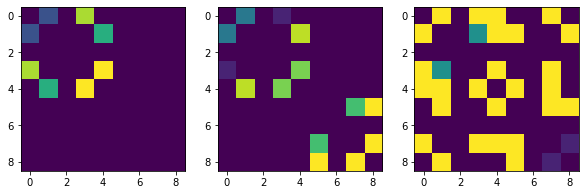

In [17]:
fig,ax = plt.subplots(1,3,figsize=(10,15))
ax[0].imshow(layer1)
ax[1].imshow(layer2)
ax[2].imshow(layer3)
adjacency_matrices = [layer1, layer2, layer3]

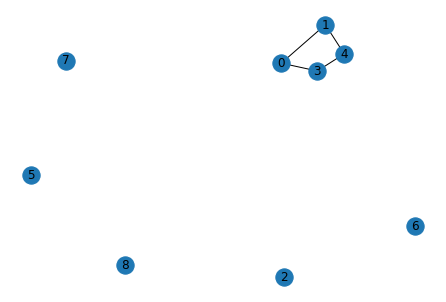

In [18]:
G1 = nx.from_numpy_matrix(layer1)
nx.draw(G1, with_labels = True)

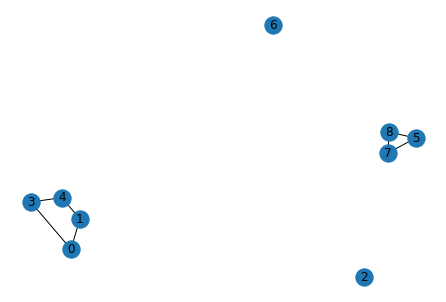

In [19]:
G2 = nx.from_numpy_matrix(layer2)
nx.draw(G2, with_labels = True)

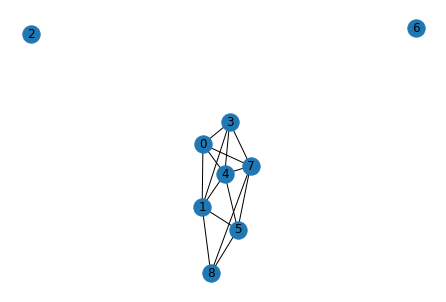

In [20]:
G3 = nx.from_numpy_matrix(layer3)
nx.draw(G3, with_labels = True)

In [27]:
n = 9
t = 3
resolution = 0.11
interlayer = [[1,2,3,4,5,6,7,8,9],[3,2,1,3,2,1,3,2,1]]
TN = temporal_network(n, t, data = 'list__adjacency', list_adjacency = adjacency_matrices, omega = 1, kind= 'ordinal')

In [22]:
igraphs = TN.create_igraph()
layers, interslice_layer, G_full = TN.layers(igraphs, interlayer)

In [28]:
for i,e in enumerate(interslice_layer.es):
    print(e)

igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 0, {'weight': 1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 1, {'weight': 2, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 2, {'weight': 3, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 3, {'weight': 4, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 4, {'weight': 5, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 5, {'weight': 6, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 6, {'weight': 7, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 7, {'weight': 8, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 8, {'weight': 9, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 9, {'weight': 3, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fbe33086d50>, 10, {'weight': 2,

In [78]:
for i,e in enumerate(layers[0].es):
    print(e)

igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 0, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 1, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 2, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 3, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 4, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 5, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 6, {'weight': 1.0, 'type': 'intraslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8486aa50>, 7, {'weight': 1.0, 'type': 'intraslice'})


In [79]:
for i,e in enumerate(interslice_layer.es):
    print(e)

igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 0, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 1, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 2, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 3, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 4, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 5, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 6, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 7, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 8, {'weight': 0.1, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850>, 9, {'weight': 0.5, 'type': 'interslice'})
igraph.Edge(<igraph.Graph object at 0x7fcd8495b850

In [34]:
layer_partitions = [la.RBConfigurationVertexPartition(H, 
                                                      weights = 'weight', 
                                                      resolution_parameter = resolution) for H in layers]
        
interslice_partition = la.RBConfigurationVertexPartition(interslice_layer, 
                                                         weights = 'weight', 
                                                         resolution_parameter = 0)
                                                     
optimiser = la.Optimiser()
        
diff = optimiser.optimise_partition_multiplex(layer_partitions + [interslice_partition], 
                                              n_iterations = 2)#,
                                             #layer_weights = [1,1,1, two_M])



#diff, parts, inter_parts= TN.leiden(igraphs,0.1,0.1)
#c_size_layers, c_size  = TN.membership(inter_parts)

In [52]:
dir(interslice_partition)

['FromAttribute',
 'FromPartition',
 '_FromCPartition',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__plot__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_default_palette',
 '_formatted_cluster_iterator',
 '_graph',
 '_len',
 '_membership',
 '_modularity',
 '_modularity_dirty',
 '_modularity_params',
 '_partition',
 '_recalculate_modularity_safe',
 '_update_internal_membership',
 'aggregate_partition',
 'as_cover',
 'bisect_value',
 'cluster_graph',
 'compare_to',
 'crossing',
 'diff_move',
 'from_coarse_partition',
 'giant',
 'graph',
 'membership',
 'modularity',
 'move_node',
 'n',
 'q',
 'quality',
 'recalculate_modularity',
 'renumber_communi

In [70]:
for i,e, in enumerate(layer_partitions[3].graph.es):
    print(e)

IndexError: list index out of range

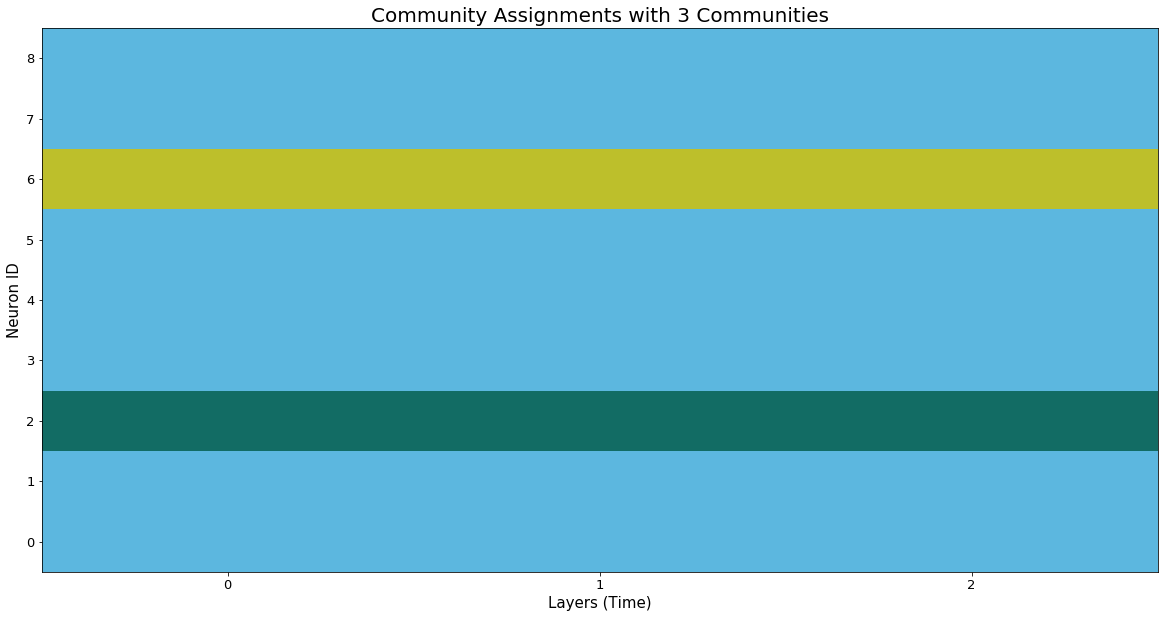

In [17]:
fig,ax = plt.subplots(1, 1, figsize = (20,10))
comms0, c0 = TN.community(TN.membership(interslice_partition)[0], ax)

In [9]:
members = [[] for i in range(inter_parts._len)]
for i,e in enumerate(inter_parts._membership):
    nodeid = i%n
    time = floor(i/n)
    members[e].append((nodeid,time))

NameError: name 'inter_parts' is not defined

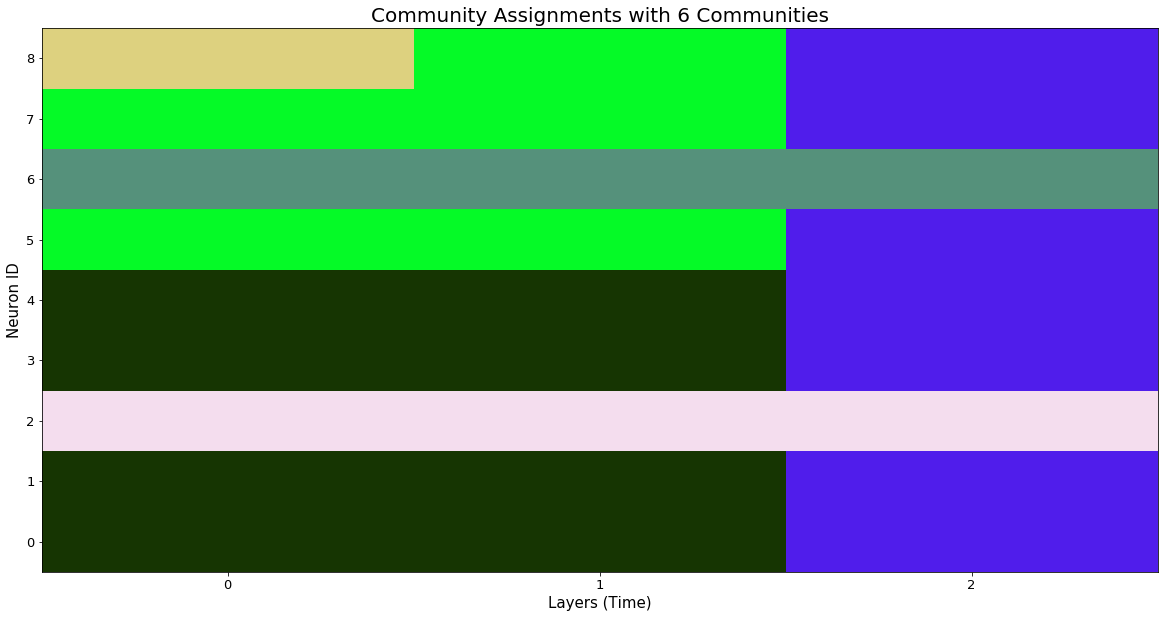

In [10]:
fig,ax = plt.subplots(1, 1, figsize = (20,10))
comms0, c0 = TN.community(members, ax)

In [14]:
def layers(G, interslice):#returns: intralayer edges of each layer, interlayer edges and the full supra matrix
    layers, interslice_layer, G_full = la.time_slices_to_layers(G, interslice_weight = interslice)
    return(layers, interslice_layer, G_full)
    
def leiden(G, interslice, resolution):
        
    layers, interslice_layer, G_full = layers(G,interslice)
        
    partitions = [la.CPMVertexPartition(H, 
                                        node_sizes = 'node_size',
                                        weights = 'weights', 
                                        resolution_parameter = resolution) for H in layers]
        
    interslice_partition = la.CPMVertexPartition(interslice_layer, 
                                                    resolution_parameter = resolution)
                                                     
    optimiser = la.Optimiser()
        
    diff = optimiser.optimise_partition_multiplex(partitions + [interslice_partition])

    return(diff, partitions, interslice_partition)